In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

In [2]:
# Implementation from HW2
# You may use np.linalg.lstsq instead

def lstsq_svd(a, b, rcond=None):
    a = np.atleast_2d(a)
    b = np.atleast_1d(b)
    u, s, vh = np.linalg.svd(a, full_matrices=False)
    if rcond is None:
        where = (s != 0.0)
    else:
        where = s > s[0] * rcond
    rank = np.count_nonzero(where)
    x = vh.T @ np.divide(u.T[:s.shape[0],:] @ b, s, out=np.zeros(a.shape[1]), where=where)
    r = a @ x - b
    cost = np.inner(r, r)
    sigma0 = cost / (b.shape[0] - rank)
    var = vh.T @ np.diag(np.power(s, -2, where=where, out=np.zeros(s.shape[0]))) @ vh * sigma0
    
    return x, cost, var

In [3]:
WIDTH, HEIGHT = 0.8, 0.8
NOISE_LEVEL = 0.0125

In [4]:
def generate_ellipse(phi):
    x = np.vstack([WIDTH / 2 * np.cos(phi), HEIGHT / 2 * np.sin(phi)]).T
    X = x + np.random.normal(loc = 0.0, scale = NOISE_LEVEL, size = x.shape)
    return X

In [5]:
lim = 5.0 / 180.0 * np.pi
phi = np.linspace(-lim, lim, 16)

data = []
data.append(generate_ellipse(phi))
data.append(np.vstack([data[0],
                       generate_ellipse(np.linspace(-lim - np.pi, lim - np.pi, 4))
                      ]))
data.append(np.vstack([data[1],
                       generate_ellipse(np.linspace(-lim - 0.5*np.pi, lim - 0.5*np.pi, 4))
                      ]))
data.append(np.vstack([data[2],
                       generate_ellipse(np.linspace(-lim + 0.5*np.pi, lim + 0.5*np.pi, 4))
                      ]))

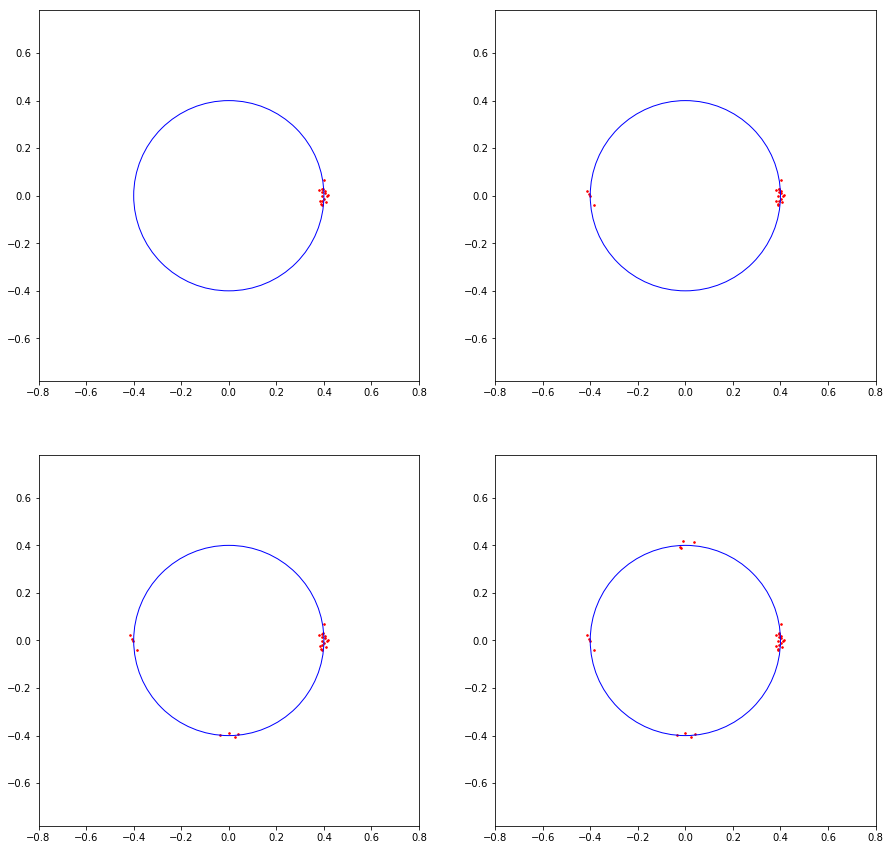

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    ax.scatter(*d.T,color='red', s=2.5)
    ax.axis('equal')
    ax.set_xlim(-WIDTH, WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    ellipse = Ellipse((0, 0), width=WIDTH, height=HEIGHT, fill=False, edgecolor='blue')
    ax.add_patch(ellipse)

Каноническое уравнение кривой второго порядка:

$$\theta_1 x_i^2 + \theta_2 y_i^2 + \theta_3 x_i y_i + \theta_4 x_i + \theta_5 y_i = 1$$

In [7]:
def create_model(X):
    A = np.hstack([X**2,X.prod(axis=1).reshape(-1,1),X])
    b = np.ones(X.shape[0])
    return A, b

expected = [6.25 6.25 0.   0.   0.  ]
0: cond = 2905.29, params = [-6.29666058 -0.14301663 -0.17530714  5.02042803  0.06833247]
1: cond = 467.67, params = [ 6.19966511  8.56688675  2.37414695  0.03247187 -1.28038582]
2: cond = 64.92, params = [ 6.2201818   3.56427264  1.85451173  0.03453036 -1.10224209]
3: cond = 33.15, params = [ 6.22550045  6.21215847 -0.33393292  0.02452962 -0.03832922]


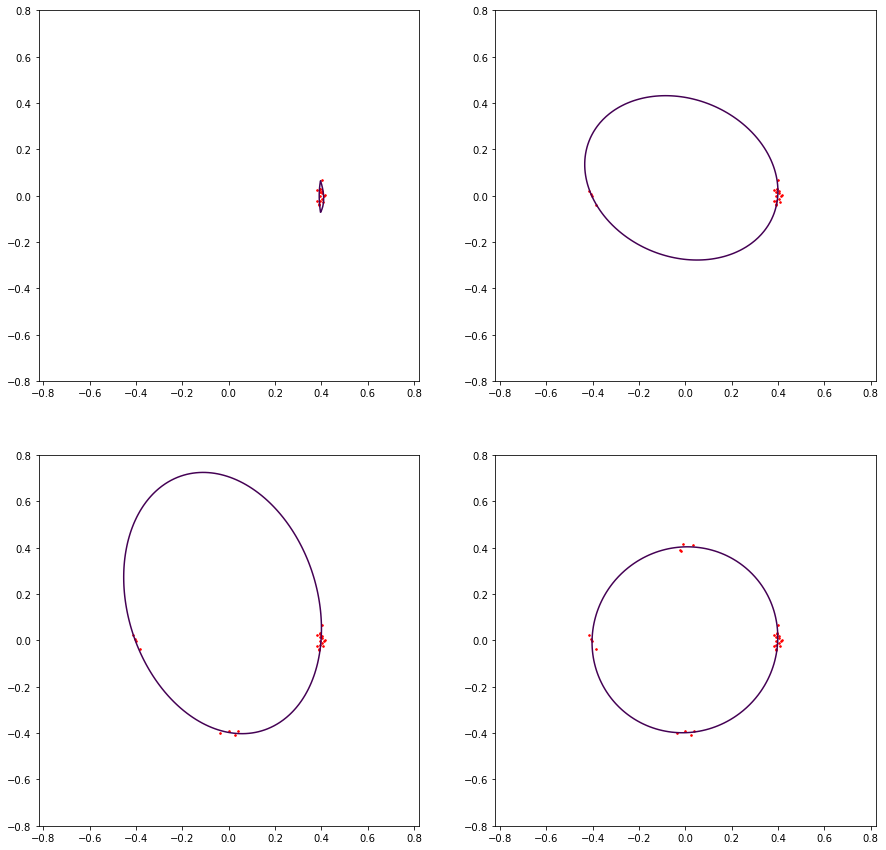

In [8]:
print("expected = {}".format(np.array([(2 / WIDTH)**2, (2 / HEIGHT)**2, 0, 0, 0])))

x_grid = np.linspace(-1.0, 1.0, 150)
y_grid = np.linspace(-1.0, 1.0, 150)
X, Y = np.meshgrid(x_grid, y_grid)
X_test = np.dstack([X,Y]).reshape(-1, 2)
A_test, b_test = create_model(X_test)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    A, b = create_model(d)
    params, *_ = lstsq_svd(A, b)
    print("{}: cond = {:.2f}, params = {}".format(i, np.linalg.cond(A), params))
    
    F = (np.dot(A_test, params) - b_test).reshape(*X.shape)
   
    ax.scatter(*d.T,color='red', s=2.5)
    ax.axis('equal')
    ax.set_xlim(-WIDTH, WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    ax.contour(X, Y, F, levels=[0])

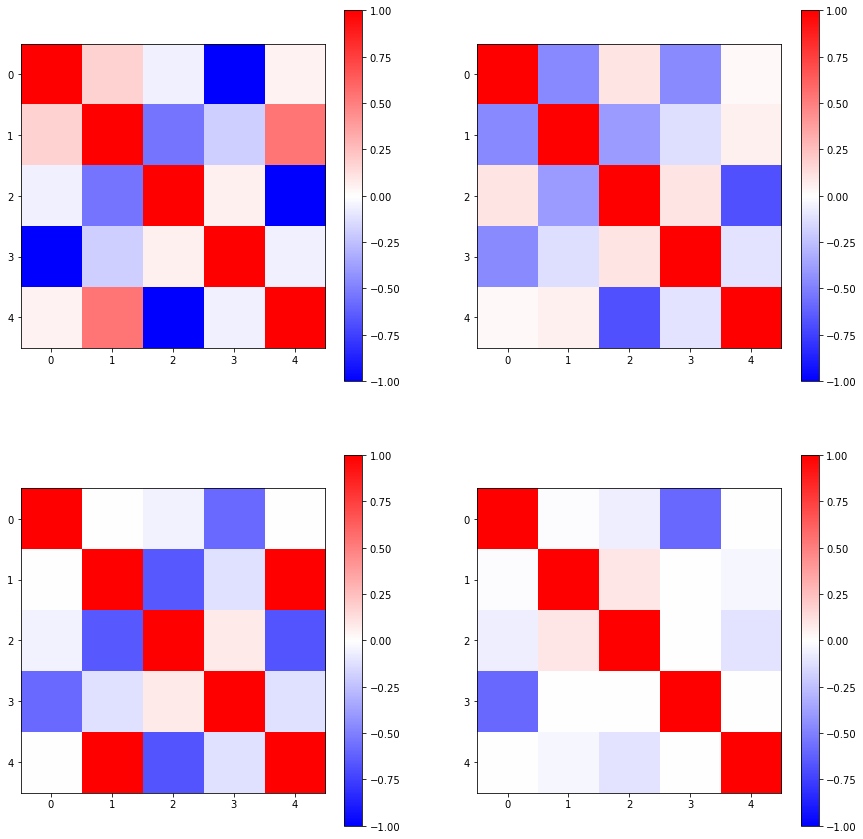

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    A, b = create_model(d)
    params, cost, var = lstsq_svd(A, b)
    sigma = np.sqrt(np.diag(var))
    cor = var / np.outer(sigma, sigma)
    im = ax.imshow(cor, cmap='bwr', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)

In [10]:
RCOND = 0.1

expected = [6.25 6.25 0.   0.   0.  ]
0: cond = 2905.29, params = [0.86378909 0.0041775  0.00599574 2.1708891  0.01467081]
1: cond = 467.67, params = [6.24455711 0.02438013 0.03679152 0.02826772 0.01088116]
2: cond = 64.92, params = [ 6.24508868  0.85874574  0.01626066  0.04161749 -2.13262181]
3: cond = 33.15, params = [ 6.22363356  6.21571325 -0.03527979  0.0244876  -0.03985539]


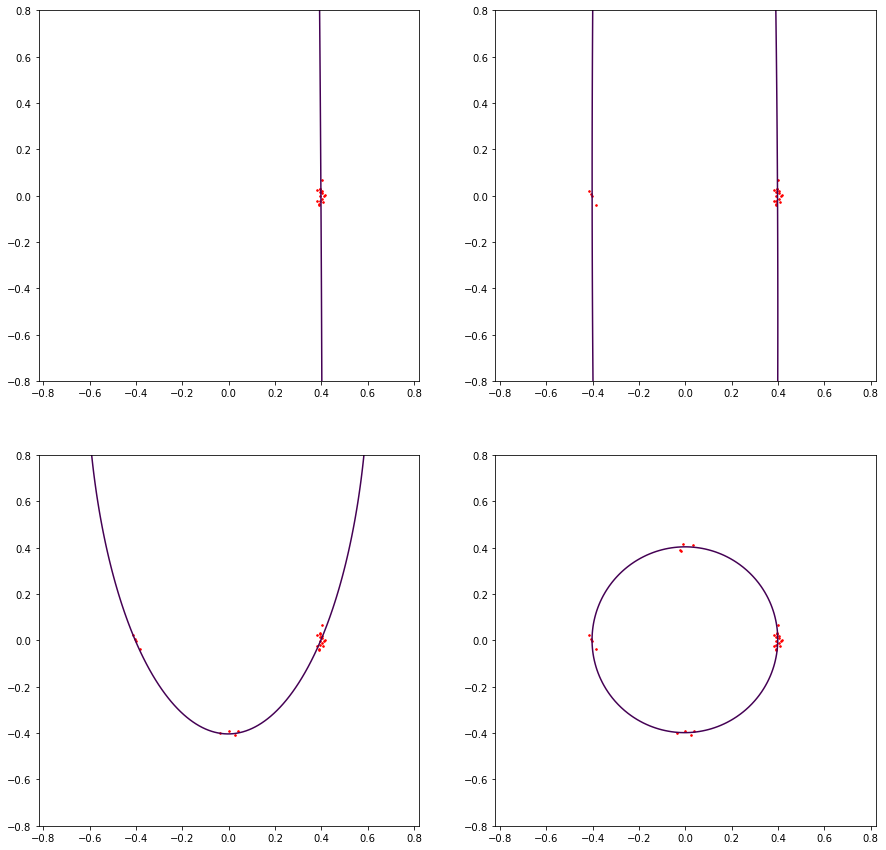

In [11]:
print("expected = {}".format(np.array([(2 / WIDTH)**2, (2 / HEIGHT)**2, 0, 0, 0])))

x_grid = np.linspace(-1.0, 1.0, 150)
y_grid = np.linspace(-1.0, 1.0, 150)
X, Y = np.meshgrid(x_grid, y_grid)
X_test = np.dstack([X,Y]).reshape(-1, 2)
A_test, b_test = create_model(X_test)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    A, b = create_model(d)
    params, *_ = lstsq_svd(A, b, rcond=RCOND)
    print("{}: cond = {:.2f}, params = {}".format(i, np.linalg.cond(A), params))
    
    F = (np.dot(A_test, params) - b_test).reshape(*X.shape)
   
    ax.scatter(*d.T,color='red', s=2.5)
    ax.axis('equal')
    ax.set_xlim(-WIDTH, WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    ax.contour(X, Y, F, levels=[0])

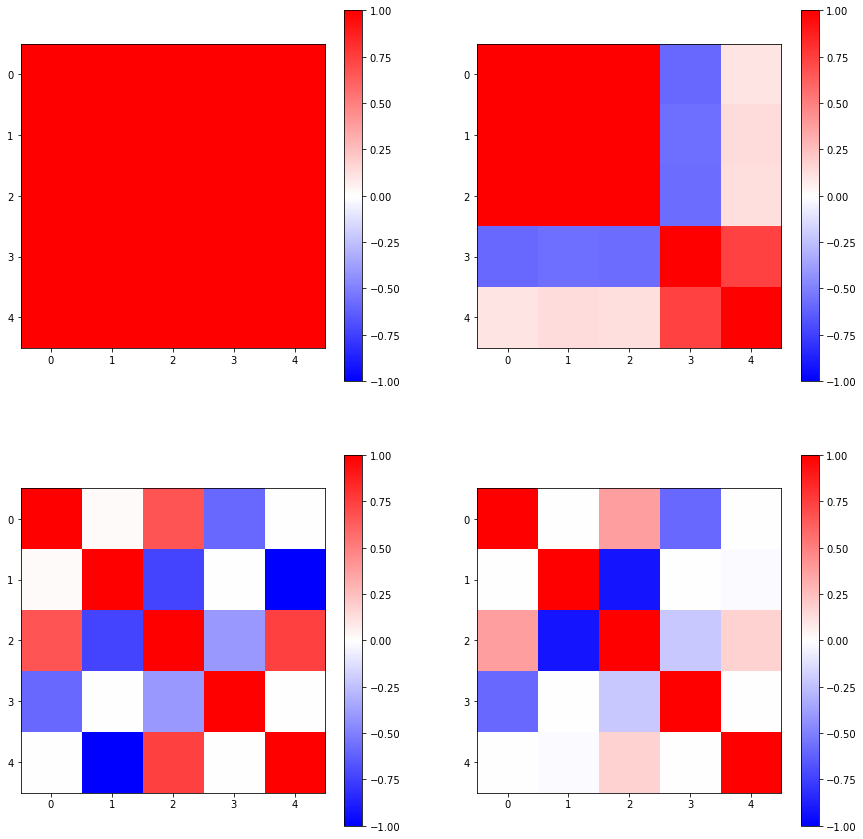

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    A, b = create_model(d)
    params, cost, var = lstsq_svd(A, b, rcond=RCOND)
    sigma = np.sqrt(np.diag(var))
    cor = var / np.outer(sigma, sigma)
    im = ax.imshow(cor, cmap='bwr', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)

### Делаем замену переменных.

Старая модель:

$$\theta_1 x^2 + \theta_2 y^2 + \theta_3 x y + \theta_4 x + \theta_5 y = 1$$

Нам бы хотелось, чтобы псевдорешение (т.е. вектор $\bf{\theta}$ с минимальной нормой) было похоже на нужный нам геометрический объект.

$$\theta_1 \approx \left({\frac{2}{W}}\right)^2$$
$$\theta_2 \approx \left({\frac{2}{H}}\right)^2$$
$$\theta_3 = \theta_4 = \theta_5 \approx 0$$

Сделаем замену переменных 

$$\mu_1 = \theta_1 - \left({\frac{2}{W}}\right)^2$$
$$\mu_2 = \theta_2 - \left({\frac{2}{H}}\right)^2$$
$$\mu_3 = \theta_3$$
$$\mu_4 = \theta_4$$
$$\mu_5 = \theta_5$$

Тогда новая модель:

$$\mu_1 x^2 + \mu_2 y^2 + \mu_3 x y + \mu_4 x + \mu_5 y = 1 - x^2 \left({\frac{2}{W}}\right)^2 - y^2 \left({\frac{2}{H}}\right)^2$$

In [13]:
def create_alt_model(X, width, height):
    A = np.hstack([X**2,X.prod(axis=1).reshape(-1,1),X])
    b = np.ones(X.shape[0]) - np.dot(X**2, [(2 / width)**2, (2 / height)**2])
    return A, b

expected = [0 0 0 0 0]
0: cond = 2905.29, params = [0.48229974 0.00233252 0.00334774 1.21212372 0.0081915 ]
1: cond = 467.67, params = [3.45608627 0.01349757 0.02036681 0.02729525 0.00609612]
2: cond = 64.92, params = [ 3.45636834  0.4821788   0.00877835  0.03479038 -1.19795701]
3: cond = 33.15, params = [ 3.44575766  3.43812229 -0.01958399  0.02448539 -0.03993559]


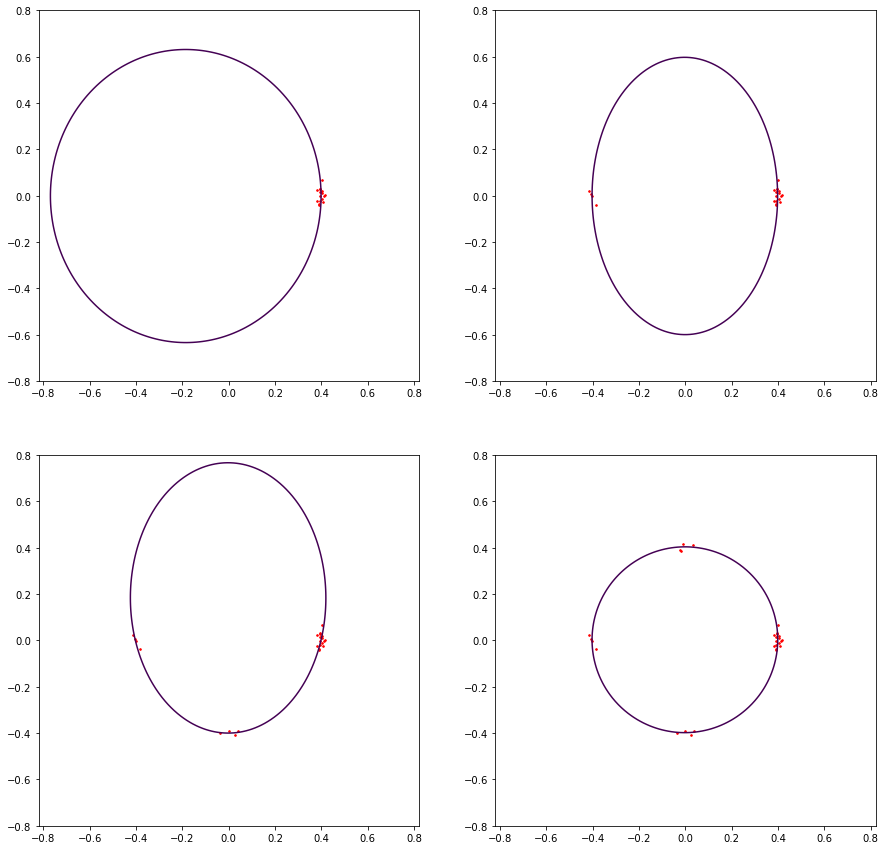

In [14]:
print("expected = {}".format(np.array([0, 0, 0, 0, 0])))

x_grid = np.linspace(-1.0, 1.0, 150)
y_grid = np.linspace(-1.0, 1.0, 150)
X, Y = np.meshgrid(x_grid, y_grid)
X_test = np.dstack([X,Y]).reshape(-1, 2)
A_test, b_test = create_alt_model(X_test, width=1.5*WIDTH, height=1.5*HEIGHT)

fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    A, b = create_alt_model(d, width=1.5*WIDTH, height=1.5*HEIGHT)
    params, *_ = lstsq_svd(A, b, rcond=RCOND)
    print("{}: cond = {:.2f}, params = {}".format(i, np.linalg.cond(A), params))
    
    F = (np.dot(A_test, params) - b_test).reshape(*X.shape)
   
    ax.scatter(*d.T,color='red', s=2.5)
    ax.axis('equal')
    ax.set_xlim(-WIDTH, WIDTH)
    ax.set_ylim(-HEIGHT, HEIGHT)
    ax.contour(X, Y, F, levels=[0])

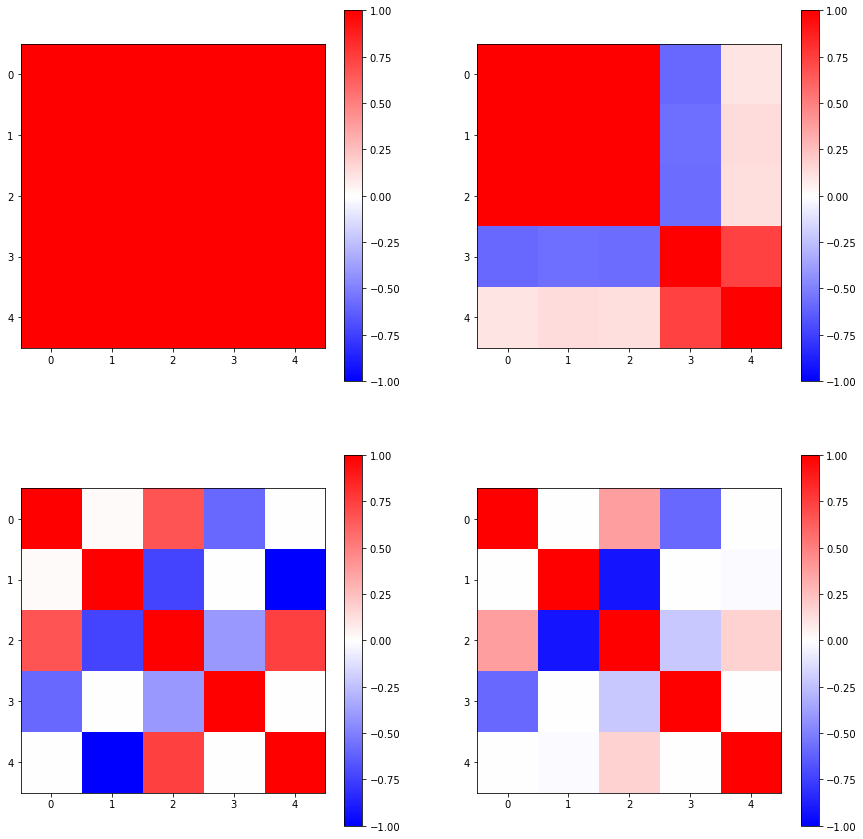

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

for i, d in enumerate(data):
    ax = axs[i // 2, i % 2]
    
    A, b = create_alt_model(d, width=WIDTH, height=HEIGHT)
    params, cost, var = lstsq_svd(A, b, rcond=RCOND)
    sigma = np.sqrt(np.diag(var))
    cor = var / np.outer(sigma, sigma)
    im = ax.imshow(cor, cmap='bwr', vmin=-1, vmax=1)
    fig.colorbar(im, ax=ax)